#   HP - TRAINING - TESTING - CV

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import os 
from tensorflow import keras
%matplotlib inline
import visualkeras
from tensorflow.keras.utils import plot_model
import logging
import pickle
from sklearn.model_selection import StratifiedKFold


print(tf.version.VERSION)
from sklearn.model_selection import train_test_split
from skimage import transform, util


from helpers_train import plot_training_history
from helpers_preproc import apply_augmentation

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

2.15.0


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
xtest = open("chihuaha muffin data/X_test.pickle","rb")
X_test = pickle.load(xtest)

xtrain = open("chihuaha muffin data/X_train.pickle","rb")
X_train = pickle.load(xtrain)


ytest = open("chihuaha muffin data/y_test.pickle","rb")
y_test = pickle.load(ytest)

ytrain = open("chihuaha muffin data/y_train.pickle","rb")
y_train = pickle.load(ytrain)

In [5]:
X_train.shape

(4732, 64, 64, 1)

**i decided here to not use validation_split while training but splitting my own validation set from the training set**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("Example X_train:", X_train[0])
print("Example y_train:", y_train[0])


X_train shape: (4258, 64, 64, 1)
y_train shape: (4258,)
X_val shape: (474, 64, 64, 1)
y_val shape: (474,)
Example X_train: [[[0.99215686]
  [0.99215686]
  [0.99215686]
  ...
  [0.99215686]
  [0.99215686]
  [0.99215686]]

 [[0.98823529]
  [0.98823529]
  [0.98823529]
  ...
  [0.99215686]
  [0.99215686]
  [0.99215686]]

 [[0.98823529]
  [0.98823529]
  [0.98823529]
  ...
  [0.99215686]
  [0.99215686]
  [0.99215686]]

 ...

 [[0.34117647]
  [0.23137255]
  [0.59607843]
  ...
  [0.58823529]
  [0.68235294]
  [0.69411765]]

 [[0.18823529]
  [0.37254902]
  [0.36078431]
  ...
  [0.6627451 ]
  [0.64705882]
  [0.62352941]]

 [[0.31372549]
  [0.60392157]
  [0.39607843]
  ...
  [0.52941176]
  [0.63137255]
  [0.61176471]]]
Example y_train: 1


In [7]:
augmented_X_train_list = [apply_augmentation(X_train[i], y_train[i]) for i in range(len(X_train))]


#this is a list where each element of this list is a list of 5 transformations
len(augmented_X_train_list)


4258

In [8]:
import pandas as pd

# flatten the nested list
flattened_augmented_list = [item for sublist in augmented_X_train_list for item in sublist]

# df is a better representation 
df_augmented = pd.DataFrame(flattened_augmented_list, columns=['image', 'label'])


print(df_augmented.head())
print(df_augmented.shape)


                                               image  label
0  [[0.9921568627450981, 0.9921568627450981, 0.99...      1
1  [[0.0, 0.0, 0.008825577246295615, 0.0427793997...      1
2  [[0.9921568627450981, 0.9921568627450981, 0.99...      1
3  [[0.3137254901960784, 0.6039215686274509, 0.39...      1
4  [[1.0, 0.999626574727616, 0.7837001326886176, ...      1
(25548, 2)


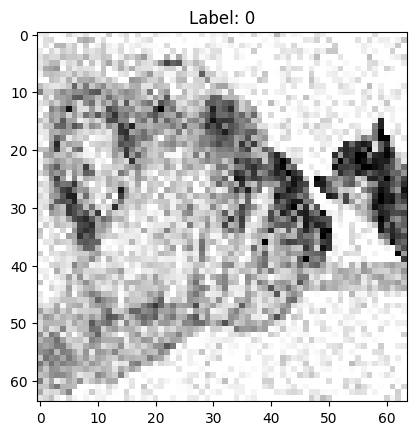

In [9]:
image_to_plot = df_augmented['image'].iloc[880]

#  image
plt.imshow(image_to_plot, cmap='gray')  
plt.title(f"Label: {df_augmented['label'].iloc[880]}") 
plt.show()


In [10]:
for i in range(len(df_augmented)):
    shape = df_augmented['image'].iloc[i].shape
    if shape != (64,64):
        print(shape)

In [11]:
# we want nparrays remember 
aug_X_train = np.stack(df_augmented['image'].to_numpy())
aug_X_train = np.expand_dims(aug_X_train, axis=-1) # reshaping for the CNN compatibility

aug_y_train = df_augmented['label'].to_numpy()


print(aug_X_train.shape)
print(aug_y_train.shape)
print(aug_X_train[0])
print(aug_y_train[0])


(25548, 64, 64, 1)
(25548,)
[[[0.99215686]
  [0.99215686]
  [0.99215686]
  ...
  [0.99215686]
  [0.99215686]
  [0.99215686]]

 [[0.98823529]
  [0.98823529]
  [0.98823529]
  ...
  [0.99215686]
  [0.99215686]
  [0.99215686]]

 [[0.98823529]
  [0.98823529]
  [0.98823529]
  ...
  [0.99215686]
  [0.99215686]
  [0.99215686]]

 ...

 [[0.34117647]
  [0.23137255]
  [0.59607843]
  ...
  [0.58823529]
  [0.68235294]
  [0.69411765]]

 [[0.18823529]
  [0.37254902]
  [0.36078431]
  ...
  [0.6627451 ]
  [0.64705882]
  [0.62352941]]

 [[0.31372549]
  [0.60392157]
  [0.39607843]
  ...
  [0.52941176]
  [0.63137255]
  [0.61176471]]]
1


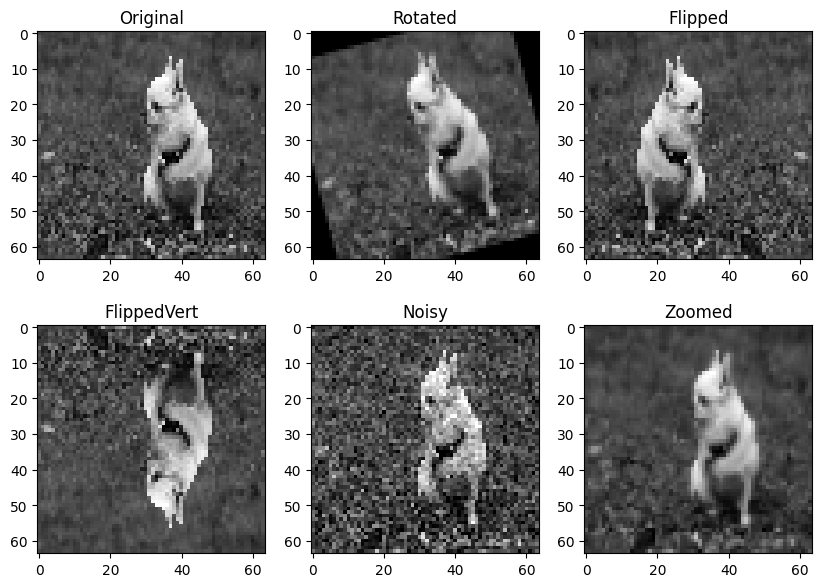

In [87]:
# Transformations
transformation_names = ['Original', 'Rotated', 'Flipped', 'FlippedVert', 'Noisy', 'Zoomed']


fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i in range(6):
    row, col = divmod(i, 3)
    axes[row, col].imshow(aug_X_train[i, :, :, 0], cmap='gray')
    axes[row, col].axis('on')
    axes[row, col].set_title(f'{transformation_names[i]}')

plt.show()


In [16]:
def hyper_builder(hp):
    hidden_dropout = hp.Float("dropout_hidden_layer", min_value = 0.1, max_value = 0.3, step = 0.05)
    dense_dropout = hp.Float("dropout_flatten_layer", min_value = 0.2, max_value = 0.5, step = 0.1)
    model = keras.models.Sequential()
    model.add(Conv2D(filters = hp.Int("convolution_1_filters", min_value = 16, max_value = 32, step = 16),
                       kernel_size = (3,3), 
                       input_shape = (64, 64, 1)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(hidden_dropout))

    model.add(Conv2D(filters = hp.Int("convolution_2_filters", min_value = 32, max_value = 64, step = 32),
                       kernel_size = (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(hidden_dropout))
    model.add(Conv2D(filters = hp.Int("convolution_3_filters", min_value = 64, max_value = 128, step = 64),
                       kernel_size = (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(hidden_dropout))

    model.add(Conv2D(filters = hp.Int("convolution_4_filters", min_value = 128, max_value = 256, step = 128), 
                       kernel_size = (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(hidden_dropout))

    model.add(Flatten())
    model.add(Dense(units = hp.Int("num_units", min_value = 64, max_value = 256, step = 64)))
    model.add(Activation("relu"))
    model.add(Dropout(dense_dropout))

    model.add(Dense(units = 1))
    model.add(Activation("sigmoid"))

    model.compile(optimizer = "adam",
                    loss = "binary_crossentropy",
                    metrics = ["accuracy"])
    return model




In [17]:
#  the tuner
tuner = kt.BayesianOptimization(
    hyper_builder,
    objective='val_accuracy',
    max_trials=40, 
    directory='kt_tuning', 
    project_name='cnn__tuning'
)

tuner.search_space_summary()


Reloading Tuner from kt_tuning/cnn__tuning/tuner0.json
Search space summary
Default search space size: 7
dropout_hidden_layer (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 16, 'sampling': 'linear'}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 64, 'sampling': 'linear'}
convolution_4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 128, 'sampling': 'linear'}
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'ste

In [13]:
# adding early stopp
early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]

In [18]:


# searching for the best hyperparameters
tuner.search(aug_X_train, aug_y_train, epochs=15, validation_data=(X_val, y_val) , callbacks=early, batch_size=32)

# best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



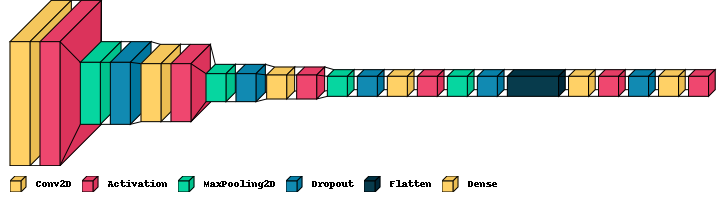

In [19]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
visualkeras.layered_view(best_model,legend=True, spacing=10, scale_xy=2)

In [20]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 activation_6 (Activation)   (None, 62, 62, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 31, 31, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        9280      
                                                                 
 activation_7 (Activation)   (None, 29, 29, 64)        0         
                                                      

In [21]:
best_hps.values

{'dropout_hidden_layer': 0.25,
 'dropout_flatten_layer': 0.4,
 'convolution_1_filters': 16,
 'convolution_2_filters': 64,
 'convolution_3_filters': 128,
 'convolution_4_filters': 128,
 'num_units': 64}

In [22]:
history = best_model.fit(aug_X_train, aug_y_train, epochs=15, callbacks = early, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/15
799/799 [==============================] - 15s 18ms/step - loss: 0.6080 - accuracy: 0.6523 - val_loss: 0.5204 - val_accuracy: 0.7405
Epoch 2/15
799/799 [==============================] - 13s 17ms/step - loss: 0.4959 - accuracy: 0.7624 - val_loss: 0.3912 - val_accuracy: 0.8207
Epoch 3/15
799/799 [==============================] - 13s 16ms/step - loss: 0.4257 - accuracy: 0.8034 - val_loss: 0.3349 - val_accuracy: 0.8439
Epoch 4/15
799/799 [==============================] - 13s 16ms/step - loss: 0.3934 - accuracy: 0.8275 - val_loss: 0.3276 - val_accuracy: 0.8460
Epoch 5/15
799/799 [==============================] - 13s 16ms/step - loss: 0.3573 - accuracy: 0.8447 - val_loss: 0.2861 - val_accuracy: 0.8734
Epoch 6/15
799/799 [==============================] - 13s 16ms/step - loss: 0.3359 - accuracy: 0.8546 - val_loss: 0.2859 - val_accuracy: 0.8840
Epoch 7/15
799/799 [==============================] - 13s 17ms/step - loss: 0.3195 - accuracy: 0.8644 - val_loss: 0.2785 - val_accuracy:

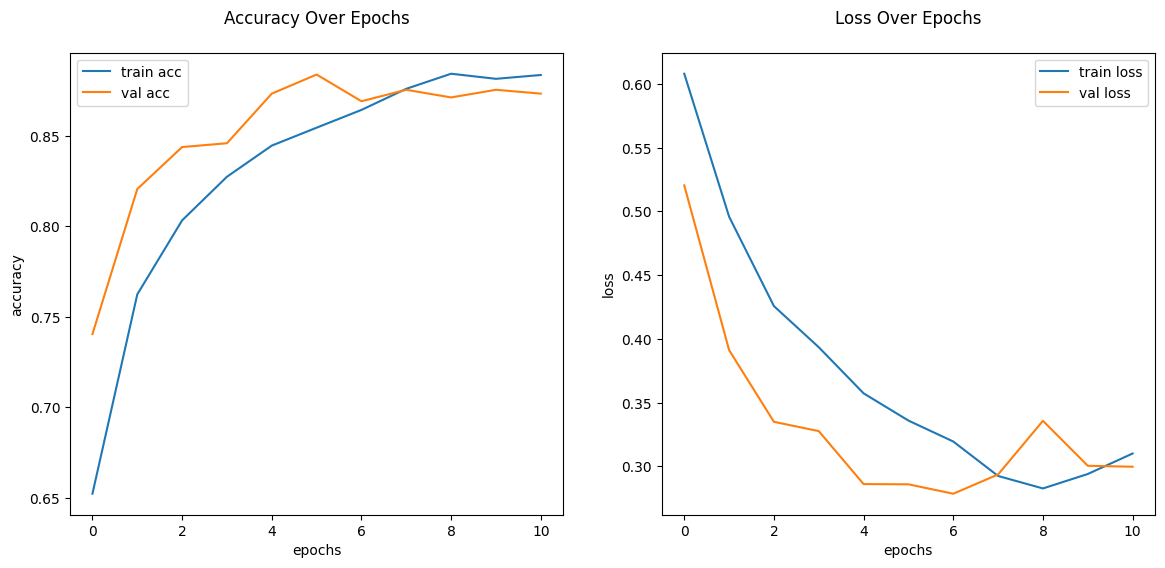

In [23]:
plot_training_history(history=history.history )

k

the model got some fluctuations 

**lets check the learning rate and the batch size maybe we can enhance it**

In [108]:
# values to try
learning_rates = [0.0001, 0.001]
batch_sizes = [32, 64, 128]
early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]

# store results
results_dict = {}

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), input_shape=(64, 64, 1)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.Dropout(0.25))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=64))
        model.add(tf.keras.layers.Activation('relu'))
        model.add(tf.keras.layers.Dropout(0.4))

        model.add(tf.keras.layers.Dense(units=1))
        model.add(tf.keras.layers.Activation('sigmoid'))

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(aug_X_train, aug_y_train, epochs=50, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=early)

        key = f"LR_{learning_rate}_BS_{batch_size}"
        results_dict[key] = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'validation_loss': history.history['val_loss'][-1],
            'validation_accuracy': history.history['val_accuracy'][-1]
        }

        print(f"Learning Rate: {learning_rate}, Batch Size: {batch_size}")
        print(f"last val loss: {history.history['val_loss'][-1]}")
        print("\n")


Epoch 1/50
799/799 [==============================] - 24s 25ms/step - loss: 0.6606 - accuracy: 0.5883 - val_loss: 0.5982 - val_accuracy: 0.7278
Epoch 2/50
799/799 [==============================] - 16s 20ms/step - loss: 0.5792 - accuracy: 0.6942 - val_loss: 0.5414 - val_accuracy: 0.7511
Epoch 3/50
799/799 [==============================] - 16s 20ms/step - loss: 0.5403 - accuracy: 0.7298 - val_loss: 0.5231 - val_accuracy: 0.7679
Epoch 4/50
799/799 [==============================] - 16s 19ms/step - loss: 0.5129 - accuracy: 0.7505 - val_loss: 0.5237 - val_accuracy: 0.7257
Epoch 5/50
799/799 [==============================] - 15s 19ms/step - loss: 0.4956 - accuracy: 0.7623 - val_loss: 0.5047 - val_accuracy: 0.7384
Epoch 6/50
799/799 [==============================] - 16s 19ms/step - loss: 0.4801 - accuracy: 0.7718 - val_loss: 0.4563 - val_accuracy: 0.8017
Epoch 7/50
799/799 [==============================] - 16s 20ms/step - loss: 0.4665 - accuracy: 0.7806 - val_loss: 0.4374 - val_accuracy:

In [109]:
# find the maximum validation accuracy
best_key = min(results_dict, key=lambda k: results_dict[k]['validation_loss'])

best_hyperparameters = results_dict[best_key]

print("Best Hyperparameters:")
print(best_hyperparameters)


Best Hyperparameters:
{'learning_rate': 0.001, 'batch_size': 128, 'validation_loss': 0.2697684168815613, 'validation_accuracy': 0.892405092716217}


In [39]:
optimal_model = tf.keras.Sequential()

optimal_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), input_shape=(64, 64, 1)))
optimal_model.add(tf.keras.layers.Activation('relu'))
optimal_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
optimal_model.add(tf.keras.layers.Dropout(0.25))

optimal_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
optimal_model.add(tf.keras.layers.Activation('relu'))
optimal_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
optimal_model.add(tf.keras.layers.Dropout(0.25))

optimal_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
optimal_model.add(tf.keras.layers.Activation('relu'))
optimal_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
optimal_model.add(tf.keras.layers.Dropout(0.25))

optimal_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)))
optimal_model.add(tf.keras.layers.Activation('relu'))
optimal_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
optimal_model.add(tf.keras.layers.Dropout(0.25))

optimal_model.add(tf.keras.layers.Flatten())
optimal_model.add(tf.keras.layers.Dense(units=64))
optimal_model.add(tf.keras.layers.Activation('relu'))
optimal_model.add(tf.keras.layers.Dropout(0.4))

optimal_model.add(tf.keras.layers.Dense(units=1))
optimal_model.add(tf.keras.layers.Activation('sigmoid'))

optimal_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history_optimal = optimal_model.fit(aug_X_train, aug_y_train, epochs=15,
                                    validation_data=(X_val, y_val),
                                    batch_size=128,
                                    callbacks=early)


Epoch 1/15
200/200 [==============================] - 11s 53ms/step - loss: 0.6331 - accuracy: 0.6292 - val_loss: 0.5393 - val_accuracy: 0.7300
Epoch 2/15
200/200 [==============================] - 9s 45ms/step - loss: 0.5353 - accuracy: 0.7358 - val_loss: 0.4402 - val_accuracy: 0.8080
Epoch 3/15
200/200 [==============================] - 7s 37ms/step - loss: 0.4576 - accuracy: 0.7840 - val_loss: 0.3653 - val_accuracy: 0.8460
Epoch 4/15
200/200 [==============================] - 8s 38ms/step - loss: 0.4008 - accuracy: 0.8193 - val_loss: 0.3334 - val_accuracy: 0.8523
Epoch 5/15
200/200 [==============================] - 7s 37ms/step - loss: 0.3815 - accuracy: 0.8291 - val_loss: 0.3656 - val_accuracy: 0.8354
Epoch 6/15
200/200 [==============================] - 8s 38ms/step - loss: 0.3746 - accuracy: 0.8335 - val_loss: 0.3098 - val_accuracy: 0.8755
Epoch 7/15
200/200 [==============================] - 7s 37ms/step - loss: 0.3475 - accuracy: 0.8459 - val_loss: 0.2921 - val_accuracy: 0.862

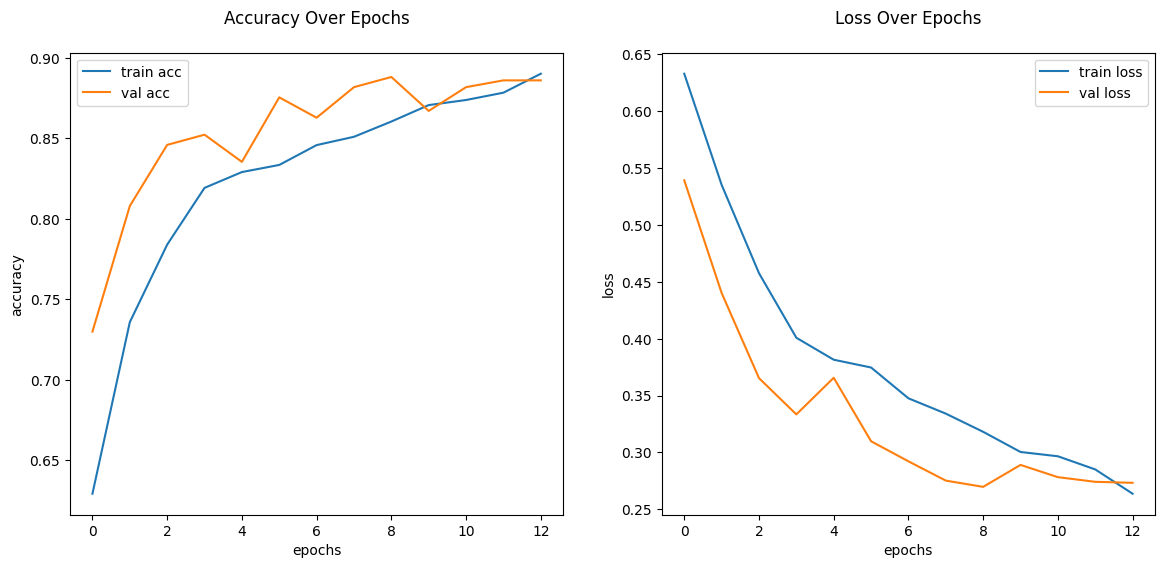

In [40]:
plot_training_history(history_optimal.history)

**okay now its a little better no?** 

**lets now save the model**

In [49]:
optimal_model.save("optimal_model.keras")

# Testing

In [41]:
# Evaluateon the test set
test_loss, test_accuracy = optimal_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


37/37 [==============================] - 0s 8ms/step - loss: 0.2795 - accuracy: 0.8826
Test Loss: 0.2794753313064575
Test Accuracy: 0.8826013803482056


37/37 [==============================] - 0s 4ms/step


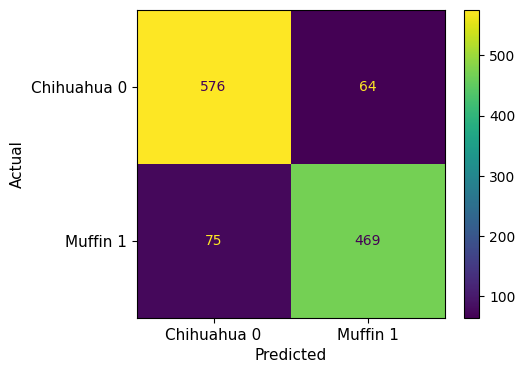

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       640
           1       0.88      0.86      0.87       544

    accuracy                           0.88      1184
   macro avg       0.88      0.88      0.88      1184
weighted avg       0.88      0.88      0.88      1184



In [67]:
# Predict on the test set
y_pred = (optimal_model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="viridis", values_format="d")


ax.set_xticklabels(["Chihuahua 0", "Muffin 1"], fontsize=11)
ax.set_yticklabels(["Chihuahua 0", "Muffin 1"], fontsize=11)
ax.set_xlabel("Predicted", fontsize=11)
ax.set_ylabel("Actual", fontsize=11)

plt.savefig('plots/confusion_matrix.png', bbox_inches='tight')

plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


## Cross Validation

In [14]:
# pre-trained optimal model
optimal = tf.keras.models.load_model("optimal_model.keras")

#  5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# to store performance metrics
validation_metrics = []


for train_index, val_index in kf.split(X_test, y_test):  
    X_train_fold, X_val_fold = X_test[train_index], X_test[val_index]
    y_train_fold, y_val_fold = y_test[train_index], y_test[val_index]

    # Clone 
    model_clone = tf.keras.models.clone_model(optimal)
    model_clone.set_weights(optimal.get_weights())
    

    model_clone.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])


    history_fold = model_clone.fit(X_train_fold, y_train_fold, epochs=30,
                                   validation_data=(X_val_fold, y_val_fold),
                                   batch_size=128, callbacks=early)

    # to evaluate the cloned model on the validation set of the fold and store metrics
    val_loss, val_accuracy = model_clone.evaluate(X_val_fold, y_val_fold)
    validation_metrics.append({'val_loss': val_loss, 'val_accuracy': val_accuracy , 'zero_one_loss': 1 - val_accuracy})

average_metrics = {
    'avg_val_loss': sum(m['val_loss'] for m in validation_metrics) / len(validation_metrics),
    'avg_val_accuracy': sum(m['val_accuracy'] for m in validation_metrics) / len(validation_metrics),
    'avg_zero_one': sum(m['zero_one_loss'] for m in validation_metrics) / len(validation_metrics)
}

print("Average Performance Metrics:")
print(average_metrics)


Epoch 1/30
8/8 [==============================] - 1s 96ms/step - loss: 0.4257 - accuracy: 0.8395 - val_loss: 0.2440 - val_accuracy: 0.9030
Epoch 2/30
8/8 [==============================] - 0s 39ms/step - loss: 0.3116 - accuracy: 0.8712 - val_loss: 0.2481 - val_accuracy: 0.9114
Epoch 3/30
8/8 [==============================] - 0s 37ms/step - loss: 0.2914 - accuracy: 0.8775 - val_loss: 0.2593 - val_accuracy: 0.9072
Epoch 4/30
8/8 [==============================] - 0s 37ms/step - loss: 0.2843 - accuracy: 0.8796 - val_loss: 0.2534 - val_accuracy: 0.9072
Epoch 5/30
8/8 [==============================] - 0s 13ms/step - loss: 0.3118 - accuracy: 0.8734
Epoch 1/30
8/8 [==============================] - 1s 96ms/step - loss: 0.3537 - accuracy: 0.8522 - val_loss: 0.3151 - val_accuracy: 0.8608
Epoch 2/30
8/8 [==============================] - 0s 40ms/step - loss: 0.3619 - accuracy: 0.8469 - val_loss: 0.3411 - val_accuracy: 0.8481
Epoch 3/30
8/8 [==============================] - 0s 37ms/step - loss

In [15]:
validation_metrics

[{'val_loss': 0.311840295791626,
  'val_accuracy': 0.8734177350997925,
  'zero_one_loss': 0.12658226490020752},
 {'val_loss': 0.29072603583335876,
  'val_accuracy': 0.8945147395133972,
  'zero_one_loss': 0.10548526048660278},
 {'val_loss': 0.24386578798294067,
  'val_accuracy': 0.9071729779243469,
  'zero_one_loss': 0.09282702207565308},
 {'val_loss': 0.3642958700656891,
  'val_accuracy': 0.8438818454742432,
  'zero_one_loss': 0.15611815452575684},
 {'val_loss': 0.24882371723651886,
  'val_accuracy': 0.8855932354927063,
  'zero_one_loss': 0.1144067645072937}]